In [1]:
import matplotlib.pyplot as plt
import torch
import os

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct, read
from diffdrr.visualization import plot_drr

In [ ]:
print('cuda available:', torch.cuda.is_available())
print('cuda device count:', torch.cuda.device_count())
print('cuda device name:', torch.cuda.get_device_name(0))
print('torch version:', torch.__version__)



cuda available: True
cuda device count: 1
cuda device name: NVIDIA GeForce RTX 5080
torch version: 2.7.1+cu128


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Read the CT

In [4]:
dir = '20_bone_lwr_ext_3x3.nii'
#subject =read(volume='20_bone_lwr_ext_3x3.nii.gz', labelmap='segment_piernas.nii')
subject =read(volume=dir)

Read puede tener los siguientes parametros
    volume: str | Path | ScalarImage,  # CT volume
    labelmap: str | Path | LabelMap = None,  # Labelmap for the CT volume
    labels: int | list = None,  # Labels from the mask of structures to render
    orientation: str | None = "AP",  # Frame-of-reference change
    bone_attenuation_multiplier: float = 1.0,  # Scalar multiplier on density of high attenuation voxels
    fiducials: torch.Tensor = None,  # 3D fiducials in world coordinates
    transform: RigidTransform = None,  # RigidTransform to apply to the volume's affine
    center_volume: bool = True,  # Move the volume's isocenter to the world origin
    resample_target=None,  # Resampling resolution argument passed to torchio.transforms.Resample
    **kwargs,  # Any additional information to be stored in the torchio.Subject

First trial

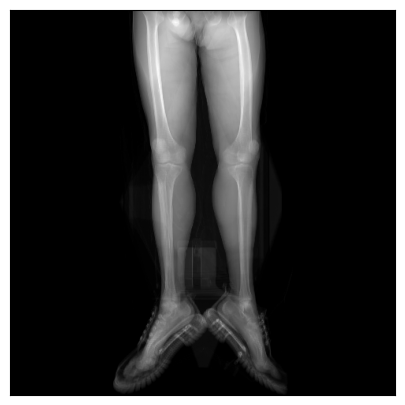

In [5]:
torch.cuda.empty_cache()
# Initialize the DRR module for generating synthetic X-rays
drr = DRR(
    subject,     # An object storing the CT volume, origin, and voxel spacing
    sdd=800.0,  # Source-to-detector distance (i.e., focal length)
    height=490,  # Image height (if width is not provided, the generated DRR is square)
    delx=2.0,    # Pixel spacing (in mm).
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[0.0 ,0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)

# 📸 Also note that DiffDRR can take many representations of SO(3) 📸
# For example, quaternions, rotation matrix, axis-angle, etc...
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=False)
plt.show()
#plt.savefig('drr_example.png', dpi=300, bbox_inches='tight')


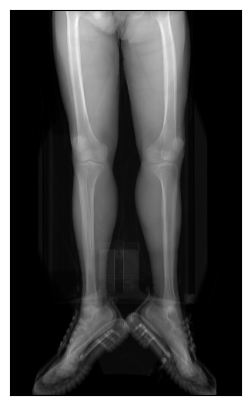

In [6]:
torch.cuda.empty_cache()
# Initialize the DRR module for generating synthetic X-rays
drr = DRR(
    subject,     # An object storing the CT volume, origin, and voxel spacing
    sdd=850.0,  # Source-to-detector distance (i.e., focal length)
    height=500,
    width=300,  # Image height (if width is not provided, the generated DRR is square)
    delx=2.0,    # Pixel spacing (in mm).
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[0.0 ,0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)

# 📸 Also note that DiffDRR can take many representations of SO(3) 📸
# For example, quaternions, rotation matrix, axis-angle, etc...
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=False)
plt.show()
#plt.savefig('drr_example.png', dpi=300, bbox_inches='tight')


In [7]:
a = []
c = 0
d = 0
for i in range(-300, 301,25):
    for j in range(-300, 301, 25):
        b = [i,j]
        # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
        a.extend([b])
#print(a) 
length = len(a)
print(length)

625


Set the path

In [8]:
path = 'Example_DRR_leg'
if not os.path.exists(path):
      os.makedirs(path)
      print("Directory created successfully!")
else:
    print("Directory already exists!")


Directory created successfully!


In [9]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 381355 KiB |   6737 MiB |  33995 MiB |  33622 MiB |\n|       from large pool | 380766 KiB |   6736 MiB |  33976 MiB |  33604 MiB |\n|       from small pool |    589 KiB |      3 MiB |     18 MiB |     18 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 381355 KiB |   6737 MiB |  33995 MiB |  33622 MiB |\n|       from large pool | 380766 KiB |   6736 MiB |

In [ ]:

# Initialize the DRR module for generating synthetic X-rays
# This is the main loop to generate DRRs for different camera poses
# It iterates over a range of yaw and pitch angles, generating and saving DRRs for each combination.
# The DRR images are saved in the specified directory with filenames indicating the angles used.
drr = DRR(
    subject,     # An object storing the CT volume, origin, and voxel spacing
    sdd=850.0,  # Source-to-detector distance (i.e., focal length)
    height=500,
    width=300, 
    delx=2.0,    # Pixel spacing (in mm).
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)

translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)

ola = 0
posexi = -300
poseyj = -300
for i in range(-300, 301,25):
    for j in range(-300, 301,25):
        rotations = torch.tensor([[i,j, 0.0]], device=device)
        #  Also note that DiffDRR can take many representations of SO(3) 
        # For example, quaternions, rotation matrix, axis-angle, etc...
        img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
        plot_drr(img, ticks=False)
        plt.savefig(os.path.join(path, f'drr_{i}_{j}.png'), dpi=300, bbox_inches='tight')
        plt.clf()  # Clear the current figure to free memory
        print(f'Saved drr_{i}_{j}.png')
        savedimages += 1
        plt.close()
        torch.cuda.empty_cache()


Saved drr_-300_-300.png
Saved drr_-300_-275.png
Saved drr_-300_-250.png
Saved drr_-300_-225.png
Saved drr_-300_-200.png
Saved drr_-300_-175.png
Saved drr_-300_-150.png
Saved drr_-300_-125.png
Saved drr_-300_-100.png
Saved drr_-300_-75.png
Saved drr_-300_-50.png
Saved drr_-300_-25.png
Saved drr_-300_0.png
Saved drr_-300_25.png
Saved drr_-300_50.png
Saved drr_-300_75.png
Saved drr_-300_100.png
Saved drr_-300_125.png
Saved drr_-300_150.png
Saved drr_-300_175.png
Saved drr_-300_200.png
Saved drr_-300_225.png
Saved drr_-300_250.png
Saved drr_-300_275.png
Saved drr_-300_300.png
Saved drr_-275_-300.png
Saved drr_-275_-275.png
Saved drr_-275_-250.png
Saved drr_-275_-225.png
Saved drr_-275_-200.png
Saved drr_-275_-175.png
Saved drr_-275_-150.png
Saved drr_-275_-125.png
Saved drr_-275_-100.png
Saved drr_-275_-75.png
Saved drr_-275_-50.png
Saved drr_-275_-25.png
Saved drr_-275_0.png
Saved drr_-275_25.png
Saved drr_-275_50.png
Saved drr_-275_75.png
Saved drr_-275_100.png
Saved drr_-275_125.png
Sav

In [ ]:
print(f"Total images saved: {savedimages}")

Total images saved: 625
